## 0. Load Data

In [1]:
from __future__ import print_function
import sys, os
import tempfile, urllib, zipfile

# Set up some globals for our file paths
BASE_DIR = tempfile.mkdtemp()
DATA_DIR = os.path.join(BASE_DIR, 'data/taxi/')
OUTPUT_DIR = os.path.join(BASE_DIR, 'chicago_taxi_output')
TRAIN_DATA = os.path.join(DATA_DIR, 'train', 'data.csv')
EVAL_DATA = os.path.join(DATA_DIR, 'eval', 'data.csv')
SERVING_DATA = os.path.join(DATA_DIR, 'serving', 'data.csv')

# Download the zip file from GCP and unzip it
zip, headers = urllib.request.urlretrieve('https://storage.googleapis.com/tfx-colab-datasets/chicago_data.zip')
zipfile.ZipFile(zip).extractall(BASE_DIR)
zipfile.ZipFile(zip).close()

print("Here's what we downloaded:")
!ls -R {os.path.join(BASE_DIR, 'data')}

Here's what we downloaded:
eval    serving train

/var/folders/l3/8q3yqb5j65zb_h8d7jzfk_gw0000gn/T/tmpmqlzxd7r/data/eval:
data.csv

/var/folders/l3/8q3yqb5j65zb_h8d7jzfk_gw0000gn/T/tmpmqlzxd7r/data/serving:
data.csv

/var/folders/l3/8q3yqb5j65zb_h8d7jzfk_gw0000gn/T/tmpmqlzxd7r/data/train:
data.csv


In [9]:
path = '/var/folders/l3/8q3yqb5j65zb_h8d7jzfk_gw0000gn/T/tmpmqlzxd7r/data/train/'

In [10]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [13]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [14]:
pf.session.load_data(name='hospital', src=FILE, fpath=path+'data.csv', check_param=True)

INFO:profiler.utility:[0.41002583503723145] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', 'nan', '?', 'NaN', 'unknown', 'None', 'none'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "pickup_community_area": "numeric",
    "fare": "numeric",
    "trip_start_month": "numeric",
    "trip_start_hour": "numeric",
    "trip_start_day": "numeric",
    "trip_start_timestamp": "numeric",
    "pickup_latitude": "numeric",
    "pickup_longitude": "numeric",
    "dropoff_latitude": "numeric",
    "dropoff_longitude": "numeric",
    "trip_miles": "numeric",
    "dropoff_census_tract": "numeric",
    "payment_type": "categorical",
    "company": "text",
    "trip_seconds": "numeric",
    "dropoff_community_area": "numeric",
    "tips": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categor

In [15]:
pf.session.ds.df.head()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,22,12.85,3,11,7,1393673400,41.920452,-87.679955,41.877406,-87.621972,0.0,1.703132e+10,cash,taxi affiliation services,720.0,32.0,0.0
1,22,5.45,8,21,7,1439675100,41.920452,-87.679955,41.906771,-87.681025,1.2,1.703124e+10,cash,dispatch taxi affiliation,360.0,24.0,0.0
2,33,0.00,5,10,4,1432118700,41.849247,-87.624135,41.849247,-87.624135,0.0,1.703184e+10,cash,northwest management llc,0.0,33.0,0.0
3,33,11.05,3,15,1,1427037300,41.849247,-87.624135,41.892508,-87.626215,0.0,1.703108e+10,cash,taxi affiliation services,900.0,8.0,0.0
4,33,11.05,5,15,6,1401464700,41.849247,-87.624135,41.892508,-87.626215,3.2,1.703108e+10,cash,nan,960.0,8.0,0.0


### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [16]:
# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [17]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [18]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[2.0979819297790527] Create Training Data start

INFO:profiler.transformer:needs multiplier = 17 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 17, and the bound is 0.00007083
INFO:profiler.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 128.26it/s]
INFO:profiler.transformer:Number of training samples: 170000
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0310
INFO:profiler.utility:[2.7141027450561523] Create Training Data execution time: 0.6161208152770996



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [38]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.03, infer_order=True)

INFO:profiler.utility:[233.52776670455933] Learn Structure start

INFO:profiler.learner:use threshold 0.0280
INFO:profiler.utility:[233.6793248653412] Learn Structure execution time: 0.15155816078186035



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [39]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[234.2171618938446] Get Dependencies start

INFO:profiler.utility:[234.27575659751892] Get Dependencies execution time: 0.058594703674316406



payment_type -> tips (0.12137949617445687)
pickup_latitude -> pickup_longitude (0.0018783470496883056)
pickup_latitude,pickup_longitude -> dropoff_latitude (0.18822036560957894)
pickup_latitude,pickup_longitude,dropoff_latitude -> dropoff_longitude (0.00208895072047249)
pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude -> dropoff_community_area (0.0845936191054308)
pickup_latitude,pickup_longitude,dropoff_community_area -> pickup_community_area (0.07971942373902588)
dropoff_latitude,dropoff_longitude,dropoff_community_area -> dropoff_census_tract (0.0789189273049742)


## 5. Visualization

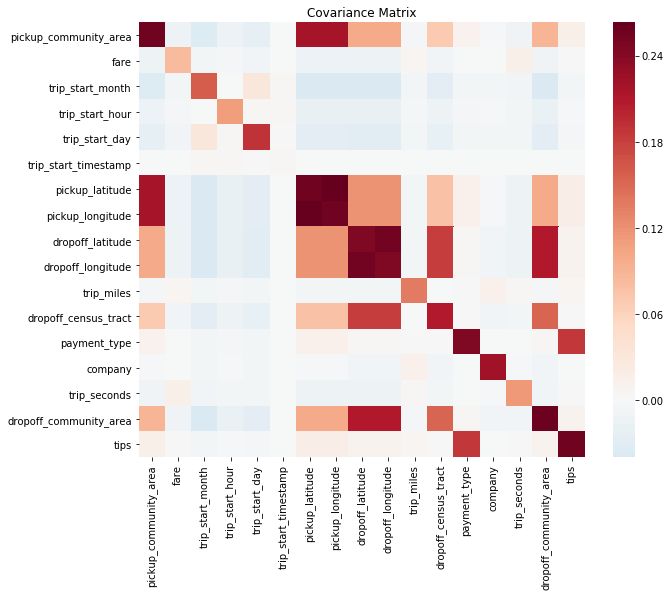

In [35]:
pf.session.visualize_covariance()

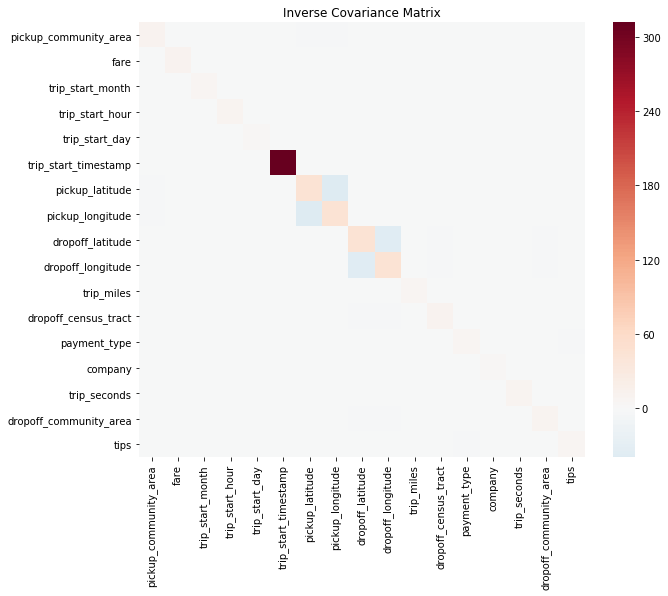

In [36]:
pf.session.visualize_inverse_covariance()

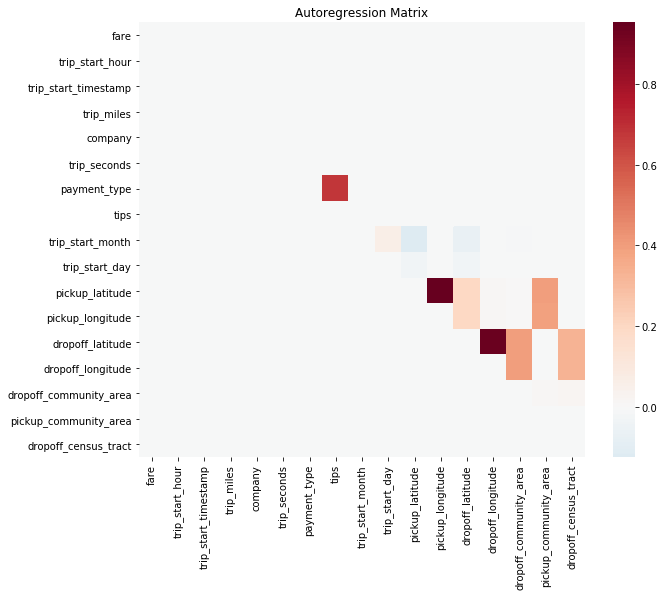

In [37]:
pf.session.visualize_autoregression()

In [23]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.410026,start: Load Data,0.000000
1,0.479351,end: Load Data,0.069325
2,2.097982,start: Create Training Data,0.000000
3,2.714103,end: Create Training Data,0.616121
4,2.719610,start: Learn Structure,0.000000
5,3.183525,start: Get Dependencies,0.000000
6,3.183525,total_execution_time,0.685446


In [24]:
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True)
i = 0
fig.suptitle('train')
for cls, group in pf.session.ds.df.groupby(['payment_type']):
    if cls == "prcard":
        continue
    if cls == "dispute":
        break
    group['tips'].hist(bins=10, ax=axs[i])
    axs[i].set_title(cls)
    axs[i].set_xlim(left=0,right=20)
    i += 1